In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33967")
client

<Client: 'tcp://127.0.0.1:33967' processes=8 threads=40, memory=157.39 GiB>

In [21]:
client.restart()

distributed.client - ERROR - Restart timed out after 20.00 seconds


Connection method: Direct,
Dashboard: http://127.0.0.1:8787/status,
Comm: tcp://127.0.0.1:38627,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: 7 hours ago,Total memory: 0 B


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import os.path as op
import os
import xrft
import gsw
import time
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
# from MITgcmutils import jmd95
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
import matplotlib as mpl
mpl.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from xlayers import finegrid, layers
# from xlayers.core import layers_numpy, layers_apply

In [4]:
ddir = '/tank/chaocean/'
topog = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 15
yend = 50

Dsig = 9.2
sigmin = 20.
nlayers = 55
# siglayers = np.linspace(19,48,nlayers)
xs, xe = (0,2)
tanh1 = np.tanh(np.arange(xs, xe, (xe-xs)/nlayers))
amp = (tanh1.max()-tanh1.min())
siglayers = (tanh1-tanh1.min())*amp**-1*Dsig + sigmin
tanh2 = np.tanh(np.arange(xs-(xe-xs)/(2*nlayers), xe+(xe-xs)/(2*nlayers), (xe-xs)/nlayers))
sigp1layers = (tanh2-tanh1.min())*amp**-1*Dsig + sigmin
# func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
# sigp1layers = func(np.arange(.5,nlayers+1.5,1))
print(siglayers,sigp1layers)

[20.         20.34783626 20.69475465 21.03984695 21.38222406 21.72102502
 22.05542541 22.38464498 22.70795438 23.02468079 23.33421255 23.63600254
 23.92957049 24.21450415 24.49045938 24.75715929 25.01439246 25.26201041
 25.49992447 25.72810197 25.94656223 26.15537208 26.35464133 26.5445181
 26.72518415 26.89685039 27.05975242 27.21414639 27.36030499 27.49851386
 27.62906814 27.75226942 27.868423   27.97783536 28.08081204 28.17765574
 28.26866467 28.35413122 28.43434077 28.50957077 28.58009001 28.64615804
 28.70802471 28.76592996 28.82010358 28.87076516 28.91812416 28.96237991
 29.00372184 29.04232966 29.0783736  29.11201471 29.14340512 29.17268843
 29.2       ] [19.82602439 20.17397561 20.52146729 20.86758519 21.21142948 21.55212404
 21.88882517 22.22072965 22.54708189 22.86718016 23.18038174 23.48610686
 23.78384163 24.07313971 24.35362294 24.62498098 24.88696994 25.13941024
 25.38218374 25.61523025 25.83854364 26.05216754 26.25619087 26.45074315
 26.63598991 26.81212805 26.97938136 2

In [6]:
tchunk = 1
xchunk = 200
ychunk = 200
sigchunk = 10
dnf = 2160
nremap = 140
nfile = 73

In [7]:
# dHT0 = xr.open_dataset(op.join(savedir,'IC_temperature-bias_%2dS-%2dN.nc'
#                                % (np.abs(ySstart),yend))).dHT0
# dHS0 = xr.open_dataset(op.join(savedir,'IC_salinity-bias_%2dS-%2dN.nc'
#                                % (np.abs(ySstart),yend))).dHS0
Cs = xr.open_zarr(op.join(tdgs,'5Dave/memb00/Max_sound-speed_1963-2012/')).Cs
Cs

<xarray.DataArray 'Cs' (Z: 46)>
dask.array<xarray-Cs, shape=(46,), dtype=float32, chunksize=(46,), chunktype=numpy.ndarray>
Coordinates:
    PHrefC   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    drF      (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    iter     int64 ...
    nmemb    int64 ...
    time     timedelta64[ns] ...

In [8]:
def sound_speed(s,th,p):
    """
    s            : salinity (psu)
    th           : potential temperature (deg C, ITS-90)
    p            : pressure (dbar)
    """
    th2 = th**2
    sqrts = np.sqrt(s)

    anum = ( 9.99843699e2 +
            th *( 7.35212840 +
                 th *(-5.45928211e-2 +
                      th * 3.98476704e-4
                     )
                ) +
            s *( 2.96938239 -
                th * 7.23268813e-3 +
                s * 2.12382341e-3
               )
           )
    aden = (1. +
            th *( 7.28606739e-3 +
                 th *(-4.60835542e-5 +
                      th *( 3.68390573e-7 +
                           th * 1.80809186e-10
                          )
                     )
                ) +
            s *( 2.14691708e-3 -
                th *( 9.27062484e-6 +
                     th2 * 1.78343643e-10
                    ) +
                sqrts *( 4.76534122e-6 +
                        th2 * 1.63410736e-9
                       )
               )
           )
    
#     anum_th =   (      7.352128400 + 
#                  th *(-1.091856422e-01 + 
#                  th *  1.195430112e-03) -
#                   s *  7.232688130e-03)

#     aden_th =   (      7.286067390e-03 +
#                  th *(-9.216710840e-05 + 
#                  th *( 1.105171719e-06 + 
#                  th *  7.232367440e-10)) +
#                   s *(-9.270624840e-06 - 
#                 th2 *  5.350309290e-10 + 
#           th *sqrts *  3.268214720e-09))

#     anum_s =    (      2.96938239 -
#                  th *  7.23268813e-03 +
#                   s *  4.24764682e-03)

#     aden_s =    (      2.14691708e-03 -
#                  th *( 9.27062484e-06 +
#                 th2 *  1.78343643e-10) +
#               sqrts *( 7.14801183e-06 + 
#                 th2 *  2.45116104e-09))

    anum_p = ( 1.04004591e-2 +
              th2 * 1.03970529e-7 +
              s * 5.18761880e-6
             )
    aden_p = 5.30848875e-6 * xr.ones_like(s)

#     s = s.where(p!=0.)
#     th = th.where(p!=0.) 
#     th2 = th2.where(p!=0.) 
#     p = p.where(p!=0.)
#     anum = anum.where(p!=0.)
#     aden = aden.where(p!=0.)
#     anum_p = anum_p.where(p!=0.)
#     aden_p = aden_p.where(p!=0.)

    pth = p*th
    anum = anum + p *( 1.04004591e-2 +
                      th2 *  1.03970529e-7 +
                      s *  5.18761880e-6 -
                      p *( 3.24041825e-8 +
                          th2 *  1.23869360e-11
                         )
                     )
    aden = aden + p *( 5.30848875e-6 -
                      pth *(th2 *  3.03175128e-16 +
                            p *  1.27934137e-17
                           )
                     )

#     anum_s = anum_s +                    p *  5.1876188e-06

#     anum_th = anum_th +                pth *( 2.07941058e-07 - 
#                                          p *  2.47738720e-11)

#     aden_th = aden_th -         p *p *(th2 *  9.09525384e-16 +
#                                          p *  1.27934137e-17) 

    anum_p = anum_p - p *( 6.4808365e-8 + th2 * 2.4773872e-11)

    aden_p = aden_p - pth *(th2 * 6.06350256e-16 +
                            p * 3.83802411e-17)


    rec_aden = aden**-1

    rho = anum*rec_aden
#     rho_s = (anum_s - aden_s*rho)*rec_aden
#     rho_th = (anum_th - aden_th*rho)*rec_aden
    rho_p = (anum_p - aden_p*rho)*rec_aden
    
    return np.sqrt(rho_p*1e-4)**-1

In [15]:
# for itime in range(1101600+dnf,1259280+dnf,dnf):
# for itime in range(1043280+dnf,1101600+dnf,dnf):
for itime in range(943920,943920+dnf,dnf):
    
    dsz = xr.open_dataset(op.join(savedir,'%4d/Zs_membs_parallel-%2d_%010d.nc' 
                                  % (year,nremap,itime)),
                          chunks={'nmemb':membchunk,'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk}
                         )
        
    grids = Grid(dsz, periodic=['X'], 
                 coords={'Z':{'center':'sig','outer':'sigp1'},
                         'Y':{'center':'YC','left':'YG'},
                         'X':{'center':'XC','left':'XG'}}
                )
    
    for nmemb in range(24,36):
        if nmemb == 24:
            ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                         % (nmemb,year)), 
                                grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                prefix=['diag_ocnSnap',
                                        'diag_Tbgt2D','diag_Tbgt3D',
                                        'diag_Sbgt2D','diag_Sbgt3D'], 
                                delta_t=2e2, iters=itime, 
                                chunks={'XC':xchunk,'XG':xchunk}
                                ).isel(time=-1)
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,
                                                        'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                        % (nmemb,year)), 
                                                grid_dir=op.join(ddir,
                                                                 'grid_chaO/gridMIT_update1/'),
                                                prefix=['diag_ocnSnap',
                                                        'diag_Tbgt2D','diag_Tbgt3D',
                                                        'diag_Sbgt2D','diag_Sbgt3D'], 
                                                delta_t=2e2, iters=itime, 
                                                chunks={'XC':xchunk,'XG':xchunk}
                                               ).isel(time=-1)],
                            dim='nmemb')
    ds.coords['nmemb'] = ('nmemb',np.arange(0,12,1))
    
#     cs = xr.apply_ufunc(sound_speed, 
#                         ds.SALT.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)), 
#                         ds.THETA.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)), 
#                         -grav*ds.Z*rhoConst*1e-4,             # pressure in [dbar]!!!!
#                         dask='parallelized', output_dtypes=[float,]
#                        ).where(ds.maskC!=0.).compute().chunk({'nmemb':membchunk,
#                                                               'XC':xchunk,'YC':ychunk})
    cs = sound_speed(ds.SALT.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)), 
                     ds.THETA.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)), 
                     -grav*ds.Z*rhoConst*1e-4
                    ).where(ds.maskC!=0.)
    rho_s = xr.apply_ufunc(drhods, 
                           ds.SALT.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)), 
                           ds.THETA.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)),
                           -grav*ds.Z*rhoConst*1e-4,             # pressure in [dbar]!!!!
                           dask='parallelized', output_dtypes=[float,]
                          ).where(ds.maskC!=0.)
    rho_th = xr.apply_ufunc(drhodt, 
                            ds.SALT.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)), 
                            ds.THETA.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)),
                            -grav*ds.Z*rhoConst*1e-4,             # pressure in [dbar]!!!!
                            dask='parallelized', output_dtypes=[float,]
                           ).where(ds.maskC!=0.)
            
    fine_drf = np.squeeze(ds.drF.sel(Z=slice(None,None)))
    fine_drc = np.squeeze(ds.drC.sel(Zp1=slice(None,None)))
#     drf_finer,mapindex,mapfact,cellindex = finegrid.finegrid(fine_drf, fine_drc, nremap)
    
    grid = Grid(ds, periodic=['X'])
    
#################################
#     rho_insitu = xr.apply_ufunc(jmd95.densjmd95, 
#                                 ds.SALT.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)), 
#                                 ds.THETA.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)),
# #                                 (ds.PHIHYD.sel(YC=slice(ySstart-12**-1,yend+2*12**-1))
#                                 -grav*ds.Z*rhoConst*1e-4, # pressure in [dbar]!!!!
#                                 dask='parallelized', output_dtypes=[float,]
#                                ).where(ds.maskC!=0.).compute().chunk({'nmemb':membchunk,
#                                                                       'XC':xchunk,'YC':ychunk}
#                                                                     )
    
#     rhox = xr.apply_ufunc(jmd95.densjmd95, 
#                           grid.interp(ds.SALT,'X').sel(YC=slice(yNstart-12**-1,
#                                                                 yend+2*12**-1)), 
#                           grid.interp(ds.THETA,'X').sel(YC=slice(yNstart-12**-1,
#                                                                  yend+2*12**-1)), 
# #                           (grid.interp(ds.PHIHYD,'X').sel(YC=slice(ySstart-12**-1,
# #                                                                    yend+2*12**-1))
#                           -grav*ds.Z*rhoConst*1e-4, 
#                           dask='parallelized', output_dtypes=[float,]
#                          ).where(ds.maskW!=0.).compute().chunk({'nmemb':membchunk,
#                                                                 'XG':xchunk,'YC':ychunk})
    
#     rhoy = xr.apply_ufunc(jmd95.densjmd95, 
#                           grid.interp(ds.SALT,'Y',boundary='fill'
#                                      ).sel(YG=slice(yNstart-12**-1,yend+2*12**-1)), 
#                           grid.interp(ds.THETA,'Y',boundary='fill'
#                                      ).sel(YG=slice(yNstart-12**-1,yend+2*12**-1)), 
# #                           (grid.interp(ds.PHIHYD,'Y',boundary='fill'
# #                                       ).sel(YG=slice(ySstart-12**-1,yend+2*12**-1))
#                           -grav*ds.Z*rhoConst*1e-4,
#                           dask='parallelized', output_dtypes=[float,]
#                          ).where(ds.maskS!=0.).compute().chunk({'nmemb':membchunk,
#                                                                 'XC':xchunk,'YG':ychunk})

    rho_insitu = xr.apply_ufunc(densjmd95, 
                                ds.SALT.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)), 
                                ds.THETA.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)),
                                -grav*ds.Z*rhoConst*1e-4,             # pressure in [dbar]!!!!
                                dask='parallelized', output_dtypes=[float,]
                               ).where(ds.maskC!=0.).compute().chunk({'nmemb':membchunk,
                                                                      'XC':xchunk,'YC':ychunk})
    rhox = xr.apply_ufunc(densjmd95, 
                          grid.interp(ds.SALT,'X').sel(YC=slice(yNstart-12**-1,yend+2*12**-1)), 
                          grid.interp(ds.THETA,'X').sel(YC=slice(yNstart-12**-1,yend+2*12**-1)), 
                          -grav*ds.Z*rhoConst*1e-4, 
                          dask='parallelized', output_dtypes=[float,]
                         ).where(ds.maskW!=0.).compute().chunk({'nmemb':membchunk,
                                                                'XG':xchunk,'YC':ychunk})
    rhoy = xr.apply_ufunc(densjmd95, 
                          grid.interp(ds.SALT,'Y',boundary='fill'
                                     ).sel(YG=slice(yNstart-12**-1,yend+2*12**-1)), 
                          grid.interp(ds.THETA,'Y',boundary='fill'
                                     ).sel(YG=slice(yNstart-12**-1,yend+2*12**-1)), 
                          -grav*ds.Z*rhoConst*1e-4,
                          dask='parallelized', output_dtypes=[float,]
                         ).where(ds.maskS!=0.).compute().chunk({'nmemb':membchunk,
                                                                'XC':xchunk,'YG':ychunk})
    
########################################
# #     dpdx = (grid.diff(ds.PHIHYD.where(ds.maskC!=0.) * grid.interp(ds.dyG,'X'),
# #                       'X'
# #                      ) * ds.rAw**-1
# #            ).where(ds.maskW!=0.)
# #     dpdy = (grid.diff(ds.PHIHYD.where(ds.maskC!=0.) 
# #                       * grid.interp(ds.dxG,'Y',boundary='fill'),
# #                       'Y',boundary='fill'
# #                      ) * ds.rAs**-1
# #            ).where(ds.maskS!=0.)
    dpdx = (grid.diff(ds.PHIHYD.where(ds.maskC!=0.),'X') 
            * ds.dxC**-1
           ).where(ds.maskW!=0.)
    dpdy = (grid.diff(ds.PHIHYD.where(ds.maskC!=0.),'Y',boundary='fill') 
            * ds.dyC**-1
           ).where(ds.maskS!=0.)
# #     dpdx.coords['nmemb'] = ('nmemb',ds.nmemb.data)
# #     dpdy.coords['nmemb'] = ('nmemb',ds.nmemb.data)
    
########################################
    swfrac = .62 * np.exp(ds.Zl/.6) + (1-.62) * np.exp(ds.Zl/20.)
    swfrac1 = (.62 * np.exp(ds.Zl.shift(Zl=-1)/.6) + (1-.62) 
               * np.exp(ds.Zl.shift(Zl=-1)/20.))
    Qsw = (ds.oceQsw / (rhoConst*Cp) / (ds.drF*ds.hFacC) 
           * (swfrac - swfrac1).data
          ).where(ds.maskC!=0.)
    Tflx = ((ds.TFLUX - ds.oceQsw) 
            / (rhoConst*Cp*ds.drF[0]*ds.hFacC.isel(Z=0))
           ).where(ds.maskInC!=0.)
    tsurf_corr = 0.                  # linFSConverveTr = F.
    Surf_corr = (tsurf_corr - ds.WTHMASS[:,0].where(ds.maskInC!=0.)
                ) / (ds.drF[0]*ds.hFacC.isel(Z=0))
#     DibaT = (ds.Diss_TH.where(ds.maskC!=0.) + Qsw).load()
#     DibaT.isel(Z=0)[:] += (Tflx + Surf_corr).load()
    DibaT = ds.Diss_TH.where(ds.maskC!=0.) + Qsw
    DibaT = DibaT + xr.concat([xr.DataArray((Tflx+Surf_corr).data.reshape((len(ds.nmemb),1,
                                                                           len(ds.YC),len(ds.XC)
                                                                          )),
                                            dims=['nmemb','Z','YC','XC'],
                                            coords={'nmemb':ds.nmemb.data,
                                                    'Z':np.array([ds.Z[0].data]),
                                                    'YC':ds.YC.data,'XC':ds.XC.data}),
                               xr.zeros_like(ds.Diss_TH.isel(Z=slice(1,None))
                                            ).reset_coords(drop=True)],
                              dim='Z')

########################################
    Sflx = (ds.SFLUX 
            / (rhoConst*ds.drF[0]*ds.hFacC.isel(Z=0))
           ).where(ds.maskInC!=0.)
    ssurf_corr = 0.                  # linFSConverveTr = F.
    Surf_corr = (ssurf_corr - ds.WSLTMASS[:,0].where(ds.maskInC!=0.)
                ) / (ds.drF[0]*ds.hFacC.isel(Z=0))
#     DibaS = ds.Diss_SLT.where(ds.maskC!=0.).load()
#     DibaS.isel(Z=0)[:] += (Sflx + Surf_corr).load()
    DibaS = ds.Diss_SLT.where(ds.maskC!=0.)
    DibaS = DibaS + xr.concat([xr.DataArray((Sflx+Surf_corr).data.reshape((len(ds.nmemb),1,
                                                                           len(ds.YC),len(ds.XC)
                                                                          )),
                                            dims=['nmemb','Z','YC','XC'],
                                            coords={'nmemb':ds.nmemb.data,
                                                    'Z':np.array([ds.Z[0].data]),
                                                    'YC':ds.YC.data,'XC':ds.XC.data}),
                               xr.zeros_like(ds.Diss_SLT.isel(Z=slice(1,None))
                                            ).reset_coords(drop=True)],
                              dim='Z')
    
    comp = grid.interp(ds.WVEL,'Z',boundary='fill').chunk({'Z':-1}) * grav**2 * cs**-2
    
##########################################
    start = time.time()    
# #     diaTdz = xr.DataArray(np.ones((len(ds.nmemb),
# #                                    len(ds.YC.sel(YC=slice(yNstart-12**-1,
# #                                                           yend+2*12**-1))),
# #                                    len(ds.XC),len(siglayers))),
# #                           dims=['nmemb','YC','XC','sig'],
# #                           coords={'nmemb':range(len(ds.nmemb),),
# #                                   'YC':ds.YC.sel(YC=slice(yNstart-12**-1,
# #                                                           yend+2*12**-1)).data,
# #                                   'XC':ds.XC.data,'sig':siglayers}
# #                          ) * np.nan
# #     diaSdz = diaTdz.copy()
# #     sdz = diaTdz.copy()
# #     tdz = diaTdz.copy()
# #     pxdz = xr.DataArray(np.ones((len(ds.nmemb),
# #                                  len(ds.YC.sel(YC=slice(yNstart-12**-1,yend+2*12**-1))),
# #                                  len(ds.XG),len(siglayers))),
# #                         dims=['nmemb','YC','XG','sig'],
# #                         coords={'nmemb':range(len(ds.nmemb),),
# #                                 'YC':ds.YC.sel(YC=slice(yNstart-12**-1,
# #                                                         yend+2*12**-1)).data,
# #                                 'XG':ds.XG.data,'sig':siglayers}
# #                        ) * np.nan
# #     pydz = xr.DataArray(np.ones((len(ds.nmemb),
# #                                  len(ds.YG.sel(YG=slice(yNstart-12**-1,yend+2*12**-1))),
# #                                  len(ds.XC),len(siglayers))),
# #                         dims=['nmemb','YG','XC','sig'],
# #                         coords={'nmemb':range(len(ds.nmemb),),
# #                                 'YG':ds.YG.sel(YG=slice(yNstart-12**-1,
# #                                                         yend+2*12**-1)).data,
# #                                 'XC':ds.XC.data,'sig':siglayers}
# #                        ) * np.nan
# #     udz = pxdz.copy()
# #     vdz = pydz.copy()
    
# #     for tt in range(len(ds.nmemb)):
# #         tmp1 = xr.apply_ufunc(layers_numpy, 
# #                               dpdx.isel(nmemb=tt).sel(YC=slice(yNstart-12**-1,
# #                                                                yend+2*12**-1)
# #                                                      ).chunk({'XG':xchunk}),
# #                               (rhox.isel(nmemb=tt)-rhoConst),
# #                               kwargs={'thetalayers':siglayers,'mapfact':mapfact,
# #                                       'mapindex':mapindex,'cellindex':cellindex,
# #                                       'drf_finer':drf_finer},
# #                               dask='parallelized',
# #                               input_core_dims=[['Z'],['Z']], 
# #                               output_core_dims=[['sig']],
# #                               output_dtypes=[float,], output_sizes={'sig':siglayers.size}
# #                              ).compute()

# #         tmp2 = xr.apply_ufunc(layers_numpy, 
# #                               dpdy.isel(nmemb=tt).sel(YG=slice(yNstart-12**-1,
# #                                                                yend+2*12**-1)
# #                                                      ).chunk({'YG':ychunk}),
# #                               (rhoy.isel(nmemb=tt)-rhoConst),
# #                               kwargs={'thetalayers':siglayers,'mapfact':mapfact,
# #                                       'mapindex':mapindex,'cellindex':cellindex,
# #                                       'drf_finer':drf_finer},
# #                               dask='parallelized',
# #                               input_core_dims=[['Z'],['Z']], 
# #                               output_core_dims=[['sig']],
# #                               output_dtypes=[float,], output_sizes={'sig':siglayers.size}
# #                              ).compute()

# #         pxdz[tt] = tmp1.data
# #         pydz[tt] = tmp2.data
# #         del tmp1, tmp2
    pxdz = layers_apply(dpdx.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                ).chunk({'nmemb':membchunk,'XG':xchunk}),
                        (rhox-rhoConst),
                        siglayers, fine_drf, fine_drc, fine_fact=nremap,
                        lev_name='Z', Tlev_name='sig').compute()
    pydz = layers_apply(dpdy.sel(YG=slice(yNstart-12**-1,yend+2*12**-1)
                                ).chunk({'nmemb':membchunk,'YG':ychunk}),
                        (rhoy-rhoConst),
                        siglayers, fine_drf, fine_drc, fine_fact=nremap,
                        lev_name='Z', Tlev_name='sig').compute()
        
#         tmp3 = xr.apply_ufunc(layers_numpy, 
#                               DibaT.isel(nmemb=tt).where(ds.maskC!=0.
#                                                         ).sel(YC=slice(yNstart-12**-1,
#                                                                        yend+2*12**-1)
#                                                              ).chunk({'Z':-1,'YC':ychunk,
#                                                                       'XC':xchunk}),
#                               (rho_insitu.isel(nmemb=tt)-rhoConst),
#                               kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                       'mapindex':mapindex,'cellindex':cellindex,
#                                       'drf_finer':drf_finer},
#                               dask='parallelized',
#                               input_core_dims=[['Z'],['Z']], 
#                               output_core_dims=[['sig']],
#                               output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                              ).compute()

#         tmp4 = xr.apply_ufunc(layers_numpy, 
#                               DibaS.isel(nmemb=tt).where(ds.maskC!=0.
#                                                         ).sel(YC=slice(yNstart-12**-1,
#                                                                        yend+2*12**-1)
#                                                              ).chunk({'Z':-1,'YC':ychunk,
#                                                                       'XC':xchunk}),
#                               (rho_insitu.isel(nmemb=tt)-rhoConst),
#                               kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                       'mapindex':mapindex,'cellindex':cellindex,
#                                       'drf_finer':drf_finer},
#                               dask='parallelized',
#                               input_core_dims=[['Z'],['Z']], 
#                               output_core_dims=[['sig']],
#                               output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                              ).compute()

#         diaTdz[tt] = tmp3.data
#         diaSdz[tt] = tmp4.data
#         del tmp3, tmp4
    diaTdz = layers_apply((rho_th*DibaT).where(ds.maskC!=0.).sel(YC=slice(yNstart-12**-1,
                                                                          yend+2*12**-1)
                                                                ).chunk({'nmemb':membchunk,'Z':-1,
                                                                         'YC':ychunk,'XC':xchunk}),
                          (rho_insitu-rhoConst),
                          siglayers, fine_drf, fine_drc, fine_fact=nremap,
                          lev_name='Z', Tlev_name='sig').compute()
    diaSdz = layers_apply((rho_s*DibaS).where(ds.maskC!=0.).sel(YC=slice(yNstart-12**-1,
                                                                         yend+2*12**-1)
                                                               ).chunk({'nmemb':membchunk,'Z':-1,
                                                                        'YC':ychunk,'XC':xchunk}),
                          (rho_insitu-rhoConst),
                          siglayers, fine_drf, fine_drc, fine_fact=nremap,
                          lev_name='Z', Tlev_name='sig').compute()
#     drdTdz = layers_apply(rho_th.where(ds.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
#                                                         ).chunk({'nmemb':membchunk,
#                                                                  'YC':ychunk,'XC':xchunk}),
#                           (rho_insitu-rhoConst),
#                           siglayers, fine_drf, fine_drc, fine_fact=nremap,
#                           lev_name='Z', Tlev_name='sig').compute()
#     drdsdz = layers_apply(rho_s.where(ds.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
#                                                        ).chunk({'nmemb':membchunk,
#                                                                 'YC':ychunk,'XC':xchunk}),
#                           (rho_insitu-rhoConst),
#                           siglayers, fine_drf, fine_drc, fine_fact=nremap,
#                           lev_name='Z', Tlev_name='sig').compute()
    cmpdz = layers_apply(comp.where(ds.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                     ).chunk({'nmemb':membchunk,
                                                              'YC':ychunk,'XC':xchunk}),
                         (rho_insitu-rhoConst),
                         siglayers, fine_drf, fine_drc, fine_fact=nremap,
                         lev_name='Z', Tlev_name='sig').compute()
        
#         tmp5 = xr.apply_ufunc(layers_numpy, 
#                               ds.THETA.isel(nmemb=tt).where(ds.maskC!=0.
#                                                            ).sel(YC=slice(yNstart-12**-1,
#                                                                           yend+2*12**-1)
#                                                                 ).chunk({'YC':ychunk,
#                                                                          'XC':xchunk}),
#                               (rho_insitu.isel(nmemb=tt)-rhoConst),
#                               kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                       'mapindex':mapindex,'cellindex':cellindex,
#                                       'drf_finer':drf_finer},
#                               dask='parallelized',
#                               input_core_dims=[['Z'],['Z']], 
#                               output_core_dims=[['sig']],
#                               output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                              ).compute()

#         tmp6 = xr.apply_ufunc(layers_numpy, 
#                               ds.SALT.isel(nmemb=tt).where(ds.maskC!=0.
#                                                           ).sel(YC=slice(yNstart-12**-1,
#                                                                          yend+2*12**-1)
#                                                                ).chunk({'YC':ychunk,
#                                                                         'XC':xchunk}),
#                               (rho_insitu.isel(nmemb=tt)-rhoConst),
#                               kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                       'mapindex':mapindex,'cellindex':cellindex,
#                                       'drf_finer':drf_finer},
#                               dask='parallelized',
#                               input_core_dims=[['Z'],['Z']], 
#                               output_core_dims=[['sig']],
#                               output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                              ).compute()

#         tdz[tt] = tmp5.data
#         sdz[tt] = tmp6.data
#         del tmp5, tmp6
    tdz = layers_apply(ds.THETA.where(ds.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                       ).chunk({'nmemb':membchunk,
                                                                'YC':ychunk,'XC':xchunk}),
                       (rho_insitu-rhoConst),
                       siglayers, fine_drf, fine_drc, fine_fact=nremap,
                       lev_name='Z', Tlev_name='sig').compute()
    sdz = layers_apply(ds.SALT.where(ds.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                      ).chunk({'nmemb':membchunk,
                                                               'YC':ychunk,'XC':xchunk}),
                       (rho_insitu-rhoConst),
                       siglayers, fine_drf, fine_drc, fine_fact=nremap,
                       lev_name='Z', Tlev_name='sig').compute()
        
# #         tmp7 = xr.apply_ufunc(layers_numpy, 
# #                               ds.UVEL.isel(nmemb=tt).where(ds.maskW!=0.
# #                                                           ).sel(YC=slice(yNstart-12**-1,
# #                                                                          yend+2*12**-1)
# #                                                                ).chunk({'YC':ychunk,
# #                                                                         'XG':xchunk}),
# #                               (rhox.isel(nmemb=tt)-rhoConst),
# #                               kwargs={'thetalayers':siglayers,'mapfact':mapfact,
# #                                       'mapindex':mapindex,'cellindex':cellindex,
# #                                       'drf_finer':drf_finer},
# #                               dask='parallelized',
# #                               input_core_dims=[['Z'],['Z']], 
# #                               output_core_dims=[['sig']],
# #                               output_dtypes=[float,], output_sizes={'sig':siglayers.size}
# #                              ).compute()

# #         tmp8 = xr.apply_ufunc(layers_numpy, 
# #                               ds.VVEL.isel(nmemb=tt).where(ds.maskS!=0.
# #                                                           ).sel(YG=slice(yNstart-12**-1,
# #                                                                          yend+2*12**-1)
# #                                                                ).chunk({'YG':ychunk,
# #                                                                         'XC':xchunk}),
# #                               (rhoy.isel(nmemb=tt)-rhoConst),
# #                               kwargs={'thetalayers':siglayers,'mapfact':mapfact,
# #                                       'mapindex':mapindex,'cellindex':cellindex,
# #                                       'drf_finer':drf_finer},
# #                               dask='parallelized',
# #                               input_core_dims=[['Z'],['Z']], 
# #                               output_core_dims=[['sig']],
# #                               output_dtypes=[float,], output_sizes={'sig':siglayers.size}
# #                              ).compute()

# #         udz[tt] = tmp7.data
# #         vdz[tt] = tmp8.data
# #         del tmp7, tmp8
    udz = layers_apply(ds.UVEL.where(ds.maskW!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                      ).chunk({'nmemb':membchunk,
                                                               'YC':ychunk,'XG':xchunk}),
                       (rhox-rhoConst),
                       siglayers, fine_drf, fine_drc, fine_fact=nremap,
                       lev_name='Z', Tlev_name='sig').compute()
    vdz = layers_apply(ds.VVEL.where(ds.maskS!=0.).sel(YG=slice(yNstart-12**-1,yend+2*12**-1)
                                                      ).chunk({'nmemb':membchunk,
                                                               'YG':ychunk,'XC':xchunk}),
                       (rhoy-rhoConst),
                       siglayers, fine_drf, fine_drc, fine_fact=nremap,
                       lev_name='Z', Tlev_name='sig').compute()
    

#     pxdz = pxdz.chunk({'nmemb':membchunk,'sig':sigchunk,'XG':xchunk,'YC':ychunk})
#     pydz = pydz.chunk({'nmemb':membchunk,'sig':sigchunk,'XC':xchunk,'YG':ychunk})
    diaTdz = diaTdz.chunk({'nmemb':membchunk,'YC':ychunk,'XC':xchunk})
    diaSdz = diaSdz.chunk({'nmemb':membchunk,'YC':ychunk,'XC':xchunk})
#     drdTdz = drdTdz.chunk({'nmemb':membchunk,'YC':ychunk,'XC':xchunk})
#     drdsdz = drdsdz.chunk({'nmemb':membchunk,'YC':ychunk,'XC':xchunk})
    cmpdz = cmpdz.chunk({'nmemb':membchunk,'YC':ychunk,'XC':xchunk})
#     tdz = tdz.chunk({'nmemb':membchunk,'YC':ychunk,'XC':xchunk})
#     sdz = sdz.chunk({'nmemb':membchunk,'YC':ychunk,'XC':xchunk})
#     udz = udz.chunk({'nmemb':membchunk,'sig':sigchunk,'XG':xchunk,'YC':ychunk})
#     vdz = vdz.chunk({'nmemb':membchunk,'sig':sigchunk,'XC':xchunk,'YG':ychunk})
    
    del rho_insitu
    del rhoy, rhox
    end = time.time()
    print("Interpolation done. Lapse:", end-start)
    
    
##########################################    
    buoyb = -grav * dsz.sig * rhoConst**-1
    buoybp1 = -grav * dsz.sigp1 * rhoConst**-1
    
#     _dT = -grids.diff(tdz.chunk({'nmemb':membchunk,'YC':ychunk,'XC':xchunk})
#                       * dsz.dzetaF**-1,
#                       'Z',boundary='fill')**-1
#     _ds = -grids.diff(sdz.chunk({'nmemb':membchunk,'YC':ychunk,'XC':xchunk})
#                       * dsz.dzetaF**-1,
#                       'Z',boundary='fill')**-1
# #     varpidz = (grids.interp(dbdT,'Z',boundary='fill') * diaTdz
# #                + grids.interp(dbds,'Z',boundary='fill') * diaSdz
# #               ).compute()
#     varpidz_db = (grids.interp(_dT,'Z',boundary='fill') * diaTdz
#                   + grids.interp(_ds,'Z',boundary='fill') * diaSdz
#                  )
#     varpidz = (varpidz_db * -grids.diff(buoybp1,'Z',boundary='fill')
#                + cmpdz).compute()
    varpidzdr = diaTdz + diaSdz
    varpidz = (-varpidzdr * grav*rhoConst**-1 
               + cmpdz
              ).compute()
    
    dsave = varpidz.to_dataset(name='varpidz')
    dsave.coords['sigp1'] = ('sigp1',sigp1layers)
    dsave.to_netcdf(op.join(savedir,'%4d/Varpidz-compressible_membs_parallel-%2d_%010d.nc' 
                            % (year,nremap,itime)))
    dsave.close()
#     dsave = varpidz_db.to_dataset(name='varpidz_db')
    dsave = vdz.to_dataset(name='vdz')
    dsave['udz'] = udz
    dsave['tdz'] = tdz
    dsave['sdz'] = sdz
    dsave['pxdz'] = pxdz
    dsave['pydz'] = pydz
    dsave.coords['sigp1'] = ('sigp1',sigp1layers)
    dsave.to_netcdf(op.join(savedir,'%4d/Dyn_membs_parallel-%2d_%010d.nc' 
                            % (year,nremap,itime)))
    dsave.close()
    dsz.close()
    ds.close()

#     del cs, rho_th, rho_s
    del varpidz, tdz, sdz, diaTdz, diaSdz, cmpdz
    del vdz, udz, pydz, pxdz
#     client.restart()
    
    print(itime)

Interpolation done. Lapse: 1344.8100290298462
943920


In [9]:
years = np.arange(1963,2013,dtype=int)
ntimes = np.arange(790560,8672400+dnf,dnf).reshape(len(years),nfile)
dd = 11
yystart = 47
print(years[yystart],ntimes[yystart,dd:])

2010 [8225280 8227440 8229600 8231760 8233920 8236080 8238240 8240400 8242560
 8244720 8246880 8249040 8251200 8253360 8255520 8257680 8259840 8262000
 8264160 8266320 8268480 8270640 8272800 8274960 8277120 8279280 8281440
 8283600 8285760 8287920 8290080 8292240 8294400 8296560 8298720 8300880
 8303040 8305200 8307360 8309520 8311680 8313840 8316000 8318160 8320320
 8322480 8324640 8326800 8328960 8331120 8333280 8335440 8337600 8339760
 8341920 8344080 8346240 8348400 8350560 8352720 8354880 8357040]


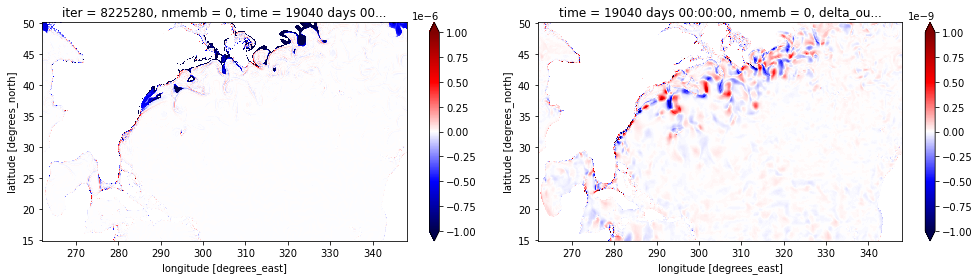

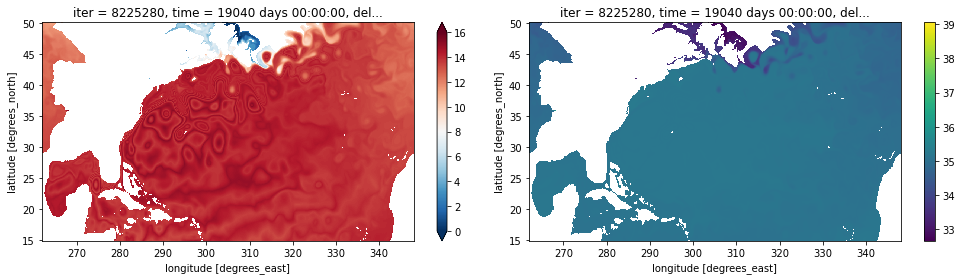

8225280
8227440
8229600
8231760
8233920
8236080
8238240
8240400
8242560
8244720
8246880
8249040
8251200
8253360
8255520
8257680
8259840
8262000
8264160
8266320
8268480
8270640
8272800
8274960
8277120
8279280
8281440
8283600
8285760
8287920
8290080
8292240
8294400
8296560
8298720
8300880
8303040
8305200
8307360
8309520
8311680
8313840
8316000
8318160
8320320
8322480
8324640
8326800
8328960
8331120
8333280
8335440
8337600
8339760
8341920
8344080
8346240
8348400
8350560
8352720
8354880
8357040
DONE!!
8359200
8361360
8363520
8365680
8367840
8370000
8372160
8374320
8376480
8378640
8380800
8382960
8385120
8387280
8389440
8391600
8393760
8395920
8398080
8400240
8402400
8404560
8406720
8408880
8411040
8413200
8415360
8417520
8419680
8421840
8424000
8426160
8428320
8430480
8432640
8434800
8436960
8439120
8441280
8443440
8445600
8447760
8449920
8452080
8454240
8456400
8458560
8460720
8462880
8465040
8467200
8469360
8471520
8473680
8475840
8478000
8480160
8482320
8484480
8486640
8488800
8490960
8

In [10]:
import warnings
warnings.filterwarnings("ignore")

dCs = 1e-5
ystart = yNstart
yy = yystart

imemb = 0


for year in years[yystart:]:
    if year == years[yystart]:
        mtimes = ntimes[yy,dd:]
#         mtimes = ntimes[yy,:1]
    else:
        mtimes = ntimes[yy]
        
    for itime in mtimes:
        
#         if itime == mtimes[0]:
#             nmembs = np.arange(36,60)
#         else:
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                     % (imemb,year)), 
                             grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                             prefix=['diag_ocnTave','diag_ocnSurf'], 
                             delta_t=2e2, iters=itime                              
                            ).chunk({'YC':ychunk,'YG':ychunk,'XC':xchunk,'XG':xchunk})
        
#         if year == years[yystart] and itime == mtimes[0]:
        xA = (ds.hFacW * ds.dyG * ds.drF)
        yA = (ds.hFacS * ds.dxG * ds.drF)
        dxC_r = ds.dxC**-1
        dyC_r = ds.dyC**-1
        dxG_r = ds.dxG**-1
        dyG_r = ds.dyG**-1
        drF_r = ds.drF**-1
        drC_r = ds.drC**-1
        hFacC_r = ds.hFacC**-1
        rA_r = ds.rA**-1
        pres = rhoConst*grav*(-ds.Z) * 1e-4
        presp1 = grav*(-ds.Zp1)*rhoConst * 1e-4
        grid = Grid(ds, periodic=['X'])
        grid_sub = Grid(ds.sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                               YG=slice(ystart-12**-1,yend+2*12**-1)), 
                        periodic=['X']
                       )
        theta = ds.THETA.where(ds.maskC!=0.)
        salt = ds.SALT.where(ds.maskC!=0.)
        
        
        if year < 2008:
            if year < 1978:
                if year == 1963:
                    dsp = xr.open_zarr(op.join(tdgs,'PHI_5Dave/run%4d/%010d/' % (year,itime)),
                                      ).sel(nmemb=imemb).chunk({'YC':ychunk,'XC':xchunk})
                else:
                    dsp = xr.open_zarr(op.join(topog,'PHI_5Dave/run%4d/%010d/' % (year,itime)),
                                      ).sel(nmemb=imemb).chunk({'YC':ychunk,'XC':xchunk})    
            else:
                dsp = xr.open_zarr(op.join(tdgs,'PHI_5Dave/run%4d/%010d/' % (year,itime)),
                                  ).sel(nmemb=imemb).chunk({'YC':ychunk,'XC':xchunk})
        else:
            dsp = xr.open_zarr(op.join(topog,'PHI_5Dave/run%4d/%010d/' % (year,itime)),
                                      ).sel(nmemb=imemb).chunk({'YC':ychunk,'XC':xchunk}) 
        dsp.coords['time'] = ds.time
        dsp = dsp.chunk({'YC':ychunk,'XC':xchunk})
        cs = dsp.cs.where(ds.maskC!=0.).chunk({'Z':-1})
        
        phi = dsp.PHIHYD.where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                          yend+2*12**-1)
                                                ).chunk({'Z':-1})

        rho_til = rhoConst*(1. - grav*(-grid.cumsum((Cs+dCs)**-2*ds.drF, 'Z',
                                                    boundary='extend', to='outer')
                                      )
                           ).chunk({'Zp1':-1})
#         if itime == mtimes[0]:
#             print(rho_til)

############################################
#                   Rhos                   #
############################################
        rho_outer = xr.apply_ufunc(densjmd95, 
                                   grid.interp(salt,'Z',boundary='extend',to='outer'
                                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                   grid.interp(theta,'Z',boundary='extend',to='outer'
                                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                   presp1, 
                                   dask='parallelized', output_dtypes=[float,]
                    ).chunk({'XC':xchunk,'YC':ychunk})
        rhox = xr.apply_ufunc(densjmd95, 
                              grid.interp(grid.interp(salt,'X'
                                                     ).where(ds.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                                        yend+2*12**-1)),
                                          'Z',boundary='extend',to='outer'), 
                              grid.interp(grid.interp(theta,'X'
                                                     ).where(ds.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                                        yend+2*12**-1)),
                                          'Z',boundary='extend',to='outer'), 
                              presp1, 
                              dask='parallelized', output_dtypes=[float,]
               ).chunk({'XG':xchunk,'YC':ychunk})
        rhoy = xr.apply_ufunc(densjmd95, 
                              grid.interp(grid.interp(salt,'Y',boundary='fill'
                                                     ).where(ds.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                                        yend+2*12**-1)),
                                          'Z',boundary='extend',to='outer'), 
                              grid.interp(grid.interp(theta,'Y',boundary='fill'
                                                     ).where(ds.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                                        yend+2*12**-1)),
                                          'Z',boundary='extend',to='outer'), 
                              presp1,
                              dask='parallelized', output_dtypes=[float,]
               ).chunk({'XC':xchunk,'YG':ychunk})

        delta_outer = (rho_outer - rho_til).chunk({'Zp1':-1}).rename('delta_outer')
        deltax_outer = (rhox - rho_til).chunk({'Zp1':-1}).rename('deltax_outer')
        deltay_outer = (rhoy - rho_til).chunk({'Zp1':-1}).rename('deltay_outer')
#         if year == years[yystart] and itime == mtimes[0]:
#             print(delta_outer)
#             fig, axes = plt.subplots(figsize=(14,11), nrows=2, ncols=2)
#             fig.set_tight_layout(True)
#             delta_outer.isel(time=0,Zp1=0).plot(ax=axes[0,0])
#             delta_outer.isel(time=0,Zp1=1).plot(ax=axes[0,1])
#             delta_outer.isel(time=0,Zp1=20).plot(ax=axes[1,0])
#             delta_outer.isel(time=0,Zp1=40).plot(ax=axes[1,1])

##############################################
#                     Zs                     #
##############################################
#         start = time.time()
#         if year > 1968:
        zz = (xr.ones_like(ds.THETA)*ds.Z).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                yend+2*12**-1)
                                                                      ).chunk({'YC':ychunk,'XC':xchunk}
                                                                             )
        zzy = (xr.ones_like(ds.VVEL)*ds.Z).where(ds.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                                yend+2*12**-1)
                                                                      ).chunk({'YG':ychunk,'XC':xchunk}
                                                                             )
        zzx = (xr.ones_like(ds.UVEL)*ds.Z).where(ds.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                                yend+2*12**-1)
                                                                      ).chunk({'YC':ychunk,'XG':xchunk}
                                                                             )
        zetadz = grid_sub.transform(zz*ds.drF,
                                            'Z',
                                            sigp1layers,
                                            method='conservative',
                                            target_data=delta_outer)
        zetadzx = grid_sub.transform(zzx*ds.drF,
                                             'Z',
                                             sigp1layers,
                                             method='conservative',
                                             target_data=deltax_outer)
        zetadzy = grid_sub.transform(zzy*ds.drF,
                                             'Z',
                                             sigp1layers,
                                             method='conservative',
                                             target_data=deltay_outer)
##############################################
        dzz = (xr.ones_like(ds.THETA)*ds.drF).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                   yend+2*12**-1)
                                                                         ).chunk({'YC':ychunk,'XC':xchunk}
                                                                                )
        dzzy = (xr.ones_like(ds.VVEL)*ds.drF).where(ds.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                                   yend+2*12**-1)
                                                                         ).chunk({'YG':ychunk,'XC':xchunk}
                                                                                )
        dzzx = (xr.ones_like(ds.UVEL)*ds.drF).where(ds.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                                   yend+2*12**-1)
                                                                         ).chunk({'YC':ychunk,'XG':xchunk}
                                                                                )
        dzetaF = grid_sub.transform(dzz,
                                            'Z',
                                            sigp1layers,
                                            method='conservative',
                                            target_data=delta_outer)
        dzetaFx = grid_sub.transform(dzzx,
                                             'Z',
                                             sigp1layers,
                                             method='conservative',
                                             target_data=deltax_outer)
        dzetaFy = grid_sub.transform(dzzy,
                                             'Z',
                                             sigp1layers,
                                             method='conservative',
                                             target_data=deltay_outer)
##############################################
        dsave = zetadz.to_dataset(name='zdz')
        dsave['zydz'] = zetadzy
        dsave['zxdz'] = zetadzx
        dsave['dzetaF'] = dzetaF.where(dzetaF!=0.)
        dsave['dzetaFx'] = dzetaFx.where(dzetaFx!=0.)
        dsave['dzetaFy'] = dzetaFy.where(dzetaFy!=0.)
        delta = .5*(dsave.delta_outer[1:].data 
                        + dsave.delta_outer[:-1].data)
        dsave = dsave.reset_coords(drop=True)
        dsave.coords['delta'] = ('delta',delta)
    #             if year == years[yystart] and itime == mtimes[0]:
    #                 print(dsave)
    #                 fig, axes = plt.subplots(figsize=(14,11), nrows=2, ncols=2)
    #                 (zetadz/dzetaF).where(dzetaF!=0.).isel(time=0,delta_outer=10).plot(ax=axes[0,0], 
    #                                                                                    cmap='Blues_r')
    #                 (zetadz/dzetaF).where(dzetaF!=0.).isel(time=0,delta_outer=20).plot(ax=axes[0,1], 
    #                                                                                    cmap='Blues_r')
    #                 (zetadz/dzetaF).where(dzetaF!=0.).isel(time=0,delta_outer=30).plot(ax=axes[1,0], 
    #                                                                                    cmap='Blues_r')
    #                 (zetadz/dzetaF).where(dzetaF!=0.).isel(time=0,delta_outer=40).plot(ax=axes[1,1], 
    #                                                                                    cmap='Blues_r')
    #                 plt.show()
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/Zs/run%4d/%010d/' 
                                  % (imemb,year,itime)), mode='w')
        dsave.close()
        #         del dzetaF, dzetaFy, dzetaFx
        del dzz, dzzx, dzzy
        del zz, zzy, zzx, zetadz, zetadzy, zetadzx
    #         print("Zs saved.")
#         else:
#             dsz = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs/run%4d/%010d/' 
#                                        % (imemb,year,itime)))
#             dzetaF = dsz.dzetaF
#             dzetaFx = dsz.dzetaFx
#             dzetaFy = dsz.dzetaFy

##############################################
#            Dynamical variables             #
##############################################
    #         start = time.time()
#         if year > 1966:
        comp = (grid.interp(ds.WVEL,'Z',boundary='fill') 
                * grav**2 
                * (cs**-2 - (Cs+dCs)**-2)
               )
    
        if year < 2008:
            dsr = xr.open_zarr(op.join(tdgs,'Varpi_5Dave/memb%02d/run%4d/%010d/' 
                                       % (imemb,year,itime))
                              ).chunk({'YC':ychunk,'XC':xchunk})    
        else:
            dsr = xr.open_zarr(op.join(topog,'Varpi_5Dave/run%4d/%010d/' 
                                       % (year,itime))
                              ).sel(nmemb=imemb).chunk({'YC':ychunk,'XC':xchunk})
            
        dsr.coords['time'] = ds.time
        diadz = grid_sub.transform(((dsr.VarpiT + dsr.VarpiS)
                                    * ds.drF).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                               yend+2*12**-1)
                                                                     ).chunk({'Z':-1,
                                                                              'YC':ychunk,'XC':xchunk}),
                                   'Z',
                                   sigp1layers,
                                   method='conservative',
                                   target_data=delta_outer)
        cmpdz = grid_sub.transform((comp*ds.drF).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                  yend+2*12**-1)
                                                                        ).chunk({'Z':-1,
                                                                                 'YC':ychunk,'XC':xchunk}),
                                   'Z',
                                   sigp1layers,
                                   method='conservative',
                                   target_data=delta_outer)  
##############################################
        if year == years[yystart] and itime == mtimes[0]:
            fig, axes = plt.subplots(figsize=(14,4), nrows=1, ncols=2)
            fig.set_tight_layout(True)
            (diadz/dzetaF).where(dzetaF!=0.).isel(time=0,delta_outer=23).plot(ax=axes[0], 
                                                                              cmap='seismic', vmax=1e-6)
            (cmpdz/dzetaF).where(dzetaF!=0.).isel(time=0,delta_outer=23).plot(ax=axes[1], 
                                                                              cmap='seismic', vmax=1e-9)
            plt.show()
        dsave = cmpdz.to_dataset(name='cmpdz')
        dsave['diadz'] = (-grav*diadz*rhoConst**-1)
        dsave = dsave.reset_coords(drop=True)
#         delta = .5*(dsave.delta_outer[1:].data 
#                     + dsave.delta_outer[:-1].data)
        dsave.coords['delta'] = ('delta',delta)
#         if year == years[yystart] and itime == mtimes[0]:
#             print(dsave)
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/Varpi/run%4d/%010d/' 
                              % (imemb,year,itime)), mode='w')
        dsave.close()
        del diadz, cmpdz, comp
        #         print("Varpi saved.")
##############################################
        tdz = grid_sub.transform((theta*ds.drF).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk}),
                                 'Z',
                                 sigp1layers,
                                 method='conservative',
                                 target_data=delta_outer)
        sdz = grid_sub.transform((salt*ds.drF).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                                  ).chunk({'YC':ychunk,'XC':xchunk}),
                                 'Z',
                                 sigp1layers,
                                 method='conservative',
                                 target_data=delta_outer)
        if year == years[yystart] and itime == mtimes[0]:
            fig, axes = plt.subplots(figsize=(14,4), nrows=1, ncols=2)
            fig.set_tight_layout(True)
            (tdz/dzetaF).where(dzetaF!=0.).isel(time=0,delta_outer=23).plot(ax=axes[0], 
                                                                            cmap='RdBu_r', vmax=16, vmin=0)
            (sdz/dzetaF).where(dzetaF!=0.).isel(time=0,delta_outer=23).plot(ax=axes[1], 
                                                                            cmap='viridis')
            plt.show()
        dsave = tdz.to_dataset(name='tdz')
        dsave['sdz'] = sdz
        dsave = dsave.reset_coords(drop=True)
        dsave.coords['delta'] = ('delta',delta)
#         if year == years[yystart] and itime == mtimes[0]:
#             print(dsave)
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/Tracers/run%4d/%010d/' 
                                      % (imemb,year,itime)), mode='w')
        del tdz, sdz
        dsave.close()
##############################################
        dpdx = (grid_sub.diff(phi,'X') * dxC_r).where(ds.maskW!=0.)
        dpdy = (grid_sub.diff(phi,'Y',boundary='fill') * dyC_r).where(ds.maskS!=0.)
        
        pxdz = grid_sub.transform((dpdx*ds.drF).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'Z':-1,'YC':ychunk,'XG':xchunk}),
                                  'Z',
                                  sigp1layers,
                                  method='conservative',
                                  target_data=deltax_outer)
        pydz = grid_sub.transform((dpdy*ds.drF).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'Z':-1,'YG':ychunk,'XC':xchunk}),
                                  'Z',
                                  sigp1layers,
                                  method='conservative',
                                  target_data=deltay_outer)
        udz = grid_sub.transform((ds.UVEL*ds.drF).where(ds.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                                   yend+2*12**-1)
                                                                         ).chunk({'YC':ychunk,
                                                                                  'XG':xchunk}),
                                 'Z',
                                 sigp1layers,
                                 method='conservative',
                                 target_data=deltax_outer)
        vdz = grid_sub.transform((ds.VVEL*ds.drF).where(ds.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                                   yend+2*12**-1)
                                                                         ).chunk({'YG':ychunk,
                                                                                  'XC':xchunk}),
                                 'Z',
                                 sigp1layers,
                                 method='conservative',
                                 target_data=deltay_outer)
        del rho_outer, rhoy, rhox

##############################################   
        dsave = vdz.to_dataset(name='vdz')
        dsave['udz'] = udz
        dsave['pxdz'] = pxdz
        dsave['pydz'] = pydz
        dsave = dsave.reset_coords(drop=True)
        dsave.coords['delta'] = ('delta',delta)
#         if year == years[yystart] and itime == mtimes[0]:
#             print(dsave)
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/Dyns/run%4d/%010d/' 
                              % (imemb,year,itime)), mode='w')
        dsave.close()
#         del dpdx, dpdy
        del vdz, udz, pydz, pxdz
        del dzetaF, dzetaFx, dzetaFy
            
        ds.close()
        dsp.close()
        dsr.close()

        print(itime)
        
#         time.sleep(90)

    print("DONE!!")
    yy += 1